**Importing Required Libraries**


In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential

from keras.layers import Dense, Dropout, Flatten, Conv2D,Input,MaxPooling2D, Activation
from keras.layers import BatchNormalization, Input

from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, TensorBoard
from keras.optimizers import SGD, Adam

from keras.models import load_model

import cv2
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange

from glob import glob
from random import randint
import sys

**Data Pre-processing**

In [ ]:
base= '/content/drive/MyDrive/dataset/covid_data'

In [ ]:
data= glob.glob(base+'/covid/*')+ glob.glob(base+'/non_covid/*')
len(data)

200

In [ ]:
image_size = 128
batch_size = 8

In [ ]:
X = np.zeros((len(data), image_size, image_size, 3), dtype=np.uint)
y = np.zeros((len(data)), dtype=np.uint)


In [ ]:
for n, id_ in tqdm_notebook(enumerate(data), total= len(data)):
    path = id_
    
    img = cv2.imread(id_,0)
    #print(img.shape)
    x = cv2.resize(img, (image_size, image_size), interpolation= cv2.INTER_NEAREST)
    #print(x.shape)
    X[n,:,:,0] = x
    X[n,:,:,1] = x
    X[n,:,:,2] = x
    
    if 'covid' in path:
        y[n] = 1
    else:
        y[n]= 0
#     sys.exit(0)

print('Done!')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.



Done!


1


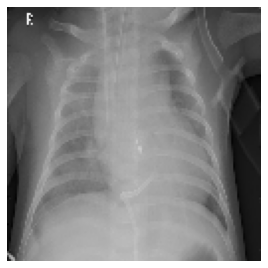

In [ ]:
plt.figure(figsize=(10,10))

index= randint(0, len(data))
plt.subplot(1, 2, 1)
plt.imshow(X[index].squeeze(), cmap='gray')
plt.axis('off')

print(y[index])

**Model Creation and Training**

In [ ]:
def create_model():
    img_input= Input((image_size, image_size, 3))
    activation_fn= 'relu'

    conv1= Conv2D(16, 3, activation= activation_fn, padding= 'same')(img_input)
    pool1= MaxPooling2D(pool_size=(2, 2))(conv1)
    # bn1 = BatchNormalization()(pool1)

    conv2= Conv2D(32, 3, activation= activation_fn, padding= 'same')(pool1)
    pool2= MaxPooling2D(pool_size=(2, 2))(conv2)
    # bn2= BatchNormalization()(pool2)

    conv3= Conv2D(64, 3, activation= activation_fn, padding= 'same')(pool2)
    pool3= MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4= Conv2D(128, 3, activation= activation_fn, padding= 'same')(pool3)
    pool4= MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5= Conv2D(256, 3, activation= activation_fn, padding= 'same')(pool4)
    pool5= MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6= Conv2D(512, 3, activation= activation_fn, padding= 'same')(pool5)
    pool6= MaxPooling2D(pool_size=(2, 2))(conv6)

    # avgPool = AveragePooling2D()(pool2)
    flat = Flatten()(pool6)
    hidden1 = Dense(128, activation="relu")(flat)
    drop = Dropout(0.5)(hidden1)
    out = Dense(2, activation="softmax")(drop)

    model= Model(img_input, out)
    model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, train_size=0.8,test_size=0.2)

model= create_model()
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

In [ ]:
name= 'covid-task-model_3'
logger= keras.callbacks.CSVLogger(name+'.log', separator=',', append=True)
earlystopper= EarlyStopping(patience= 8, verbose=1)
checkpointer= ModelCheckpoint(filepath= name+'.h5', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')
tbCallBacks= TensorBoard(log_dir= name, histogram_freq= 1, write_graph= True, write_images= True)


In [ ]:
model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size= 8, epochs= 50, callbacks= [earlystopper, checkpointer, logger, tbCallBacks ] )

Epoch 1/50
 1/20 [>.............................] - ETA: 0s - loss: 3.5790 - accuracy: 0.6250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
16/20 [=======================>......] - ETA: 0s - loss: 0.2237 - accuracy: 0.9766
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to covid-task-model_3.h5
20/20 [==============================] - 1s 37ms/step - loss: 0.1789 - accuracy: 0.9812 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
17/20 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00002: val_accuracy did not improve from 1.00000
20/20 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
16/20 [========

**Validation and Prediction of Model**

In [ ]:
model.load_weights(name+".h5")

In [ ]:
results= model.evaluate(X_val, y_val)

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[[0.05382247 0.9461776 ]]
covid


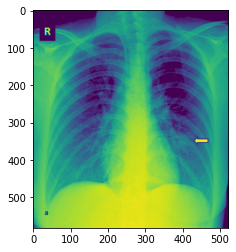

In [ ]:
from google.colab.patches import cv2_imshow

img_path = '/content/drive/MyDrive/dataset/covid-test-image.png'

model.load_weights('/content/covid-task-model_3.h5')

image_size = 128

X = np.zeros((1, image_size, image_size, 3), dtype=np.uint)

img = cv2.imread(img_path,0)
x = cv2.resize(img, (image_size, image_size), interpolation= cv2.INTER_NEAREST)
#X[0]= x.reshape(1,128,128,3)

plt.imshow(img)

prob= model.predict(X.reshape(1,128,128,3))

result= np.argmax(prob)

print(prob)
print('covid' if result==1 else 'non_covid')

[[0.05382247 0.9461776 ]]
covid


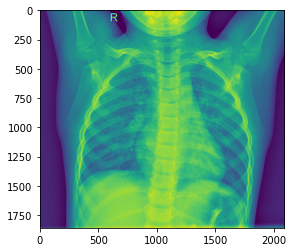

In [ ]:
img_path = '/content/drive/MyDrive/dataset/normal_lungs_image.jpeg'

model.load_weights('/content/covid-task-model_3.h5')

image_size = 128

X = np.zeros((1, image_size, image_size, 3), dtype=np.uint)

img = cv2.imread(img_path,0)
x = cv2.resize(img, (image_size, image_size), interpolation= cv2.INTER_NEAREST)
#X[0]= x.reshape(1,128,128,3)

plt.imshow(img)

prob= model.predict(X.reshape(1,128,128,3))

result= np.argmax(prob)

print(prob)
print('covid' if result==1 else 'non_covid')